In [1]:
import math
import random
import copy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Current

In [2]:
class Current:
    def __init__(self, method, in_time, dt, n_step = 10):
        self.method = method
        self.inputs = dict()
        self.in_time = in_time
        self.n_step = n_step
        for t in np.arange(0, in_time+dt, dt):
            self.inputs[t] = self.method(t)
    
    def getCurrent(self, t: float) -> float:
        return self.inputs.get(t)

    def update_I(self, time: float, end_t: float, dt: float, value: float):
        i = 0
        t = time + dt
        # reduce effect in time
        while i < self.n_step and t < end_t:
            self.inputs[t] += value * (time - t + 10*dt)
            if self.inputs[t] < 0:
                self.inputs[t] = 0
            t += dt
            i += 1

    def plot_I_t(self, times: np.ndarray, size_plot=(9, 5), color=u"#f0f"):
        plt.figure(figsize=size_plot)
        plt.plot(self.inputs.keys(), self.inputs.values(),
                color= color, linestyle='-', label='Current')

        plt.legend()
        plt.grid()
        plt.title('Current')
        plt.ylabel('Current (pA)')
        plt.xlabel('Time (msec)')
        plt.show()

## Neuron

In [3]:
class Neuron:
    def __init__(self, time_total = 100, dt = 0.25,
                R_m = 10, Tau_m = 10, V_threshold = -45,
                V_spike = 5, V_rest = -65, V_reset = -65):
        self.time_total = time_total
        self.dt = dt
        self.times = np.arange(0, self.time_total, self.dt)
        self.R_m = R_m
        self.Tau_m = Tau_m
        self.V_threshold = V_threshold
        self.V_spike = V_spike
        self.V_rest = V_rest
        self.V_reset = V_reset
        self.n_fire = 0
        self.pass_time = 0
        self.spikes = []
        self.V_data = [V_rest] * (len(self.times)+2) # save the voltage values
    
    def update(self, I) -> bool:
        index = int(self.pass_time / self.dt)
        dv = self.calculate_dv(I, index-1)
        self.V_data[index] = self.V_data[index-1] + dv
        self.pass_time += self.dt

        if self.V_data[index] >= self.V_threshold:
            self.V_data[index-1] += self.V_spike
            self.n_fire += 1
            self.spikes.append(self.pass_time - self.dt)
            self.V_data[index] = self.V_reset
            return True
        return False

    def calculate_dv(self, I_in_t: float, index) -> float:
        dv = (- self.V_data[index] + self.V_rest) + (self.R_m * I_in_t)
        dv /= self.Tau_m
        return self.dt * dv

    def plot_voltage_time(self, size_plot = (9, 5), color = u"#503C53"):
        plt.figure(figsize=size_plot)
        plt.plot(self.times , self.V_data[0:-2], color = color, label='Voltage')
        plt.plot([0,self.time_total], [self.V_threshold, self.V_threshold],
            color=u"#f00", linestyle='--', label='Threshold Voltage')

        plt.legend()
        plt.grid()
        plt.title(f'{type(self).__name__} Model')
        plt.ylabel('Membrane Potential (mV)')
        plt.xlabel('Time (msec)')
        plt.show()

## STDP

In [4]:
def simSTDP(neurons, I, time = 100, A_plus = 1, A_neg = -1):
    N = len(neurons)

    delta_T = []
    for i in range(N):
        delta_T_i = []
        for j in range(N):
            delta_T_i.append([])
        delta_T.append(delta_T_i)
    
    delta_W = []
    for i in range(N):
        delta_W_i = []
        for j in range(N):
            delta_W_i.append([])
        delta_W.append(delta_W_i)

    weight_init = 1 / N
    weights = np.ones((N, N, len(neurons[0].times)))
    weights *= weight_init   # n*n matrix that M_i,j represent w_ij, i is pre and j is post

    for t in range(1, len(neurons[0].times)):
        for i in range(N):
            fire = neurons[i].update(I[i].getCurrent(neurons[i].pass_time))
            if fire:
                for index, other in enumerate(neurons):
                    if i != index:
                        if len(neurons[index].spikes) != 0 and neurons[i].spikes[-1] != 0:
                            # LTP
                            delta_T[index][i].append(neurons[i].spikes[-1] - neurons[index].spikes[-1])
                            delta_W[index][i].append(A_plus * math.exp(-1 * math.fabs(delta_T[index][i][-1])))
                            # LTD
                            delta_T[i][index].append(neurons[index].spikes[-1] - neurons[i].spikes[-1])
                            delta_W[i][index].append(A_neg * math.exp(-1 * math.fabs(delta_T[i][index][-1])))
                            # update weights
                            weights[i, index, t:] = delta_W[i][index][-1] * neurons[0].dt + weights[i, index, t-1]
                            if weights[i, index, t] < 0: weights[i, index, t:] = 0
                            weights[index, i, t:] = delta_W[index][i][-1] * neurons[0].dt + weights[index, i, t-1]
                            if weights[index, i, t] < 0: weights[i, index, t:] = 0
                        I[index].update_I(neurons[i].pass_time, time, neurons[i].dt, weights[i, index, t])
    
    return delta_W, delta_T, weights

In [5]:
def STDP_plots(neurons, delta_W, delta_T, w):
    fig, axes = plt.subplots(3, 3, figsize=(12,12))
    fig.subplots_adjust(hspace=.5)
    for i in range(2, -1, -1):
        for j in range(2, -1, -1):
            if i != j:
                axes[i,j].scatter(delta_T[i][j], delta_W[i][j], s=5)
                axes[i,j].plot([-20, 20], [0, 0], linestyle='dotted', color='orange')
                axes[i,j].plot([0, 0], [-1, 1], linestyle='dotted', color='orange')
                axes[i,j].set_xlabel("ΔT [s]")
            axes[i,j].set_ylabel("ΔW")
            axes[i,j].title.set_text(f'Neuron {j+1}_{i+1}')
    plt.suptitle('ΔW / ΔT ',fontsize=20)
    plt.show()

    plt.figure(figsize=(12,10))
    for i, pre in enumerate(neurons):
        plt.plot(pre.times[:-1] , pre.V_data[0:-3], label=f'neuron {i+1}')
    plt.plot([0,neurons[0].time_total], [neurons[0].V_threshold, neurons[0].V_threshold],
            color='k', linestyle='--', label='Threshold Voltage')
    plt.xlabel('Time [s]')
    plt.ylabel('member potential')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.title("Raster plot")
    for i, n in enumerate(neurons):
        plt.scatter(n.spikes, [i]*len(n.spikes), marker='o', s=10, label=f'neuron {i+1}')
    yint = range(0, len(neurons))
    plt.yticks(yint)
    plt.legend()
    plt.show()

    fig, axes = plt.subplots(3, figsize=(12,12))
    for i in range(3):
        for j in range(3):
            if i != j:
                axes[i].set_title(f'Neuron {i+1}')
                axes[i].plot(neurons[0].times, w[i, j, :], label=f'neurons {j+1}')
                axes[i].legend()
    plt.xlabel('Time [s]')
    plt.suptitle('Weights',fontsize=20)
    plt.show()

### sample 1
const , const, const input

weights:
 [[0.33333333 0.27317692 0.        ]
 [0.80041414 0.33333333 0.        ]
 [0.99658763 1.38637671 0.33333333]]


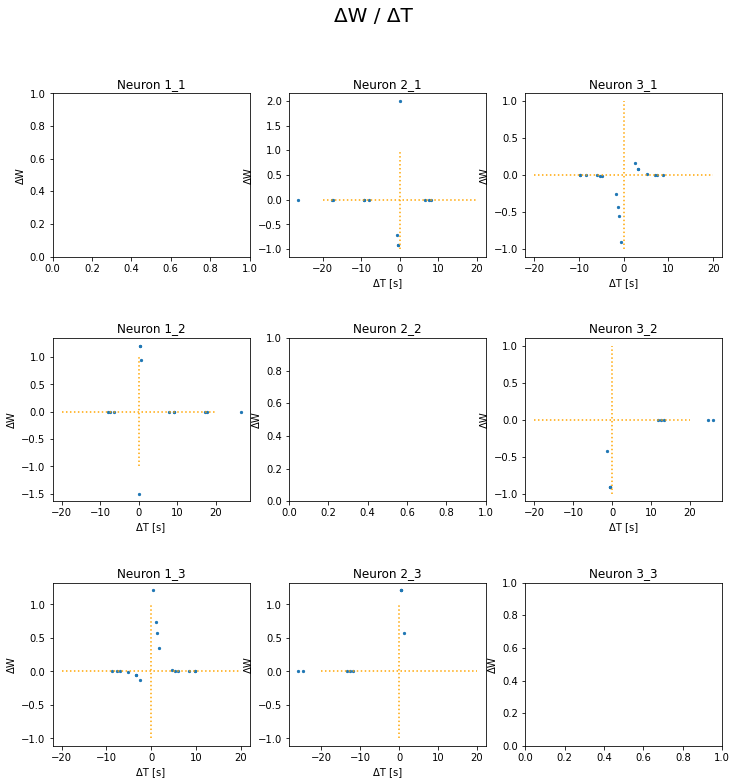

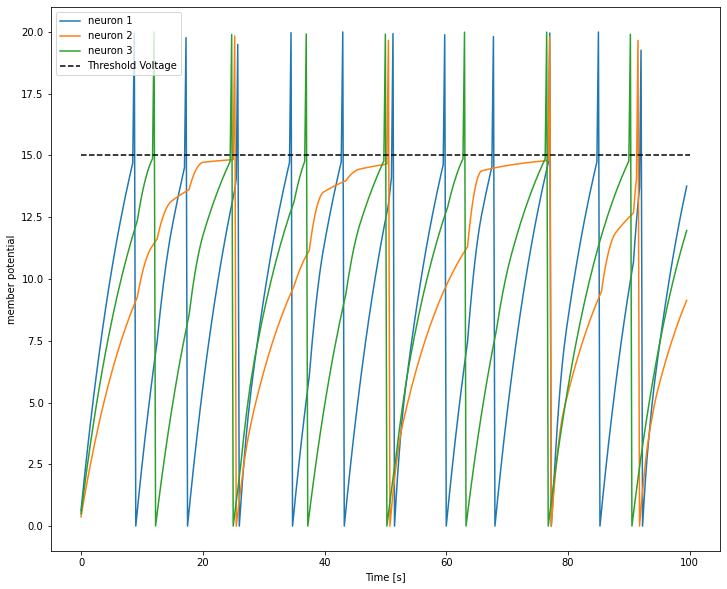

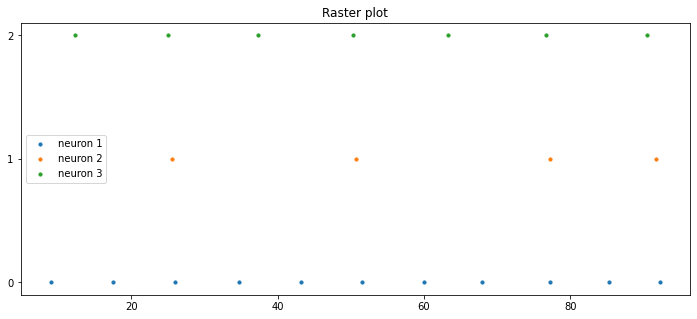

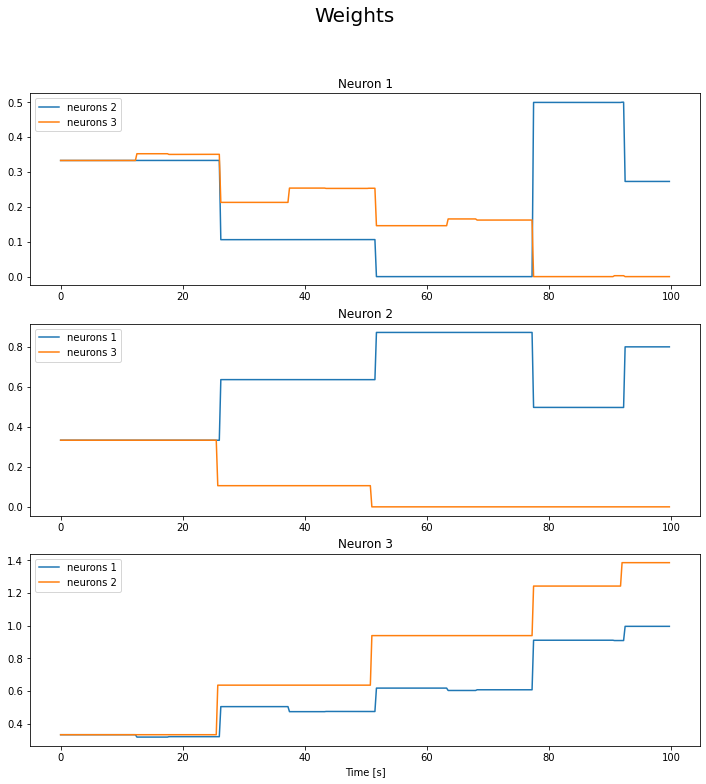

In [6]:
TIME_TOTAL = 100

n1 = Neuron(time_total=TIME_TOTAL, V_rest=0, V_reset=0, V_spike=5, V_threshold=15)
n2 = Neuron(time_total=TIME_TOTAL, V_rest=0, V_reset=0, V_spike=5, V_threshold=15)
n3 = Neuron(time_total=TIME_TOTAL, V_rest=0, V_reset=0, V_spike=5, V_threshold=15)

c1 = Current(lambda t : 2.5, TIME_TOTAL, 0.25)
c2 = Current(lambda t : 1.5, TIME_TOTAL, 0.25)
c3 = Current(lambda t : 2, TIME_TOTAL, 0.25)

neurons = [n1, n2, n3]
delta_W, delta_T, w = simSTDP(neurons, [c1, c2, c3], time=TIME_TOTAL, A_neg=-1.5, A_plus=2)

print("weights:\n" , w[:,:,-1])

STDP_plots(neurons, delta_W, delta_T, w)


### sample 2
const, sin, const inputs

weights:
 [[0.33333333 0.03443246 1.11341785]
 [1.08501333 0.33333333 0.15452654]
 [0.         0.71764041 0.33333333]]


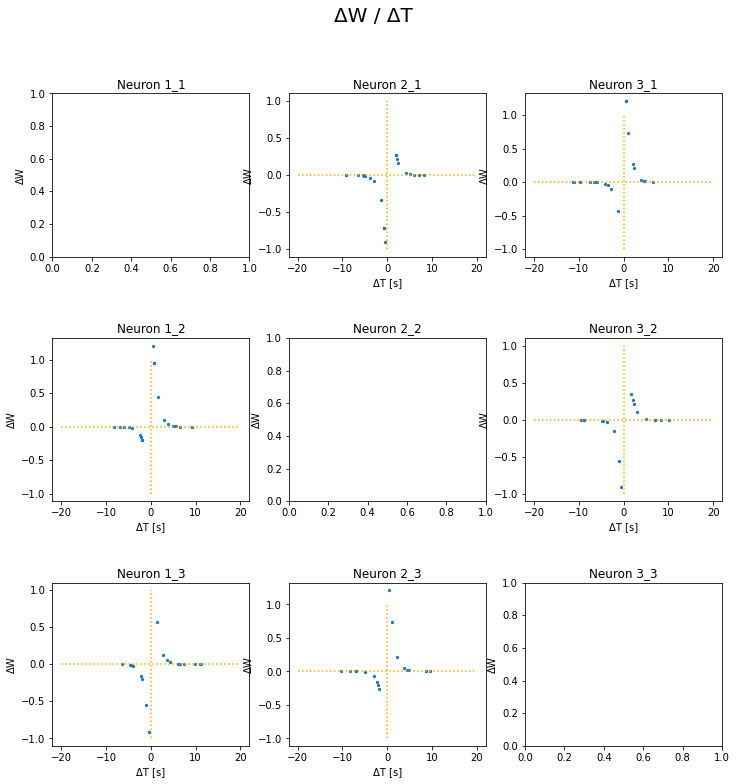

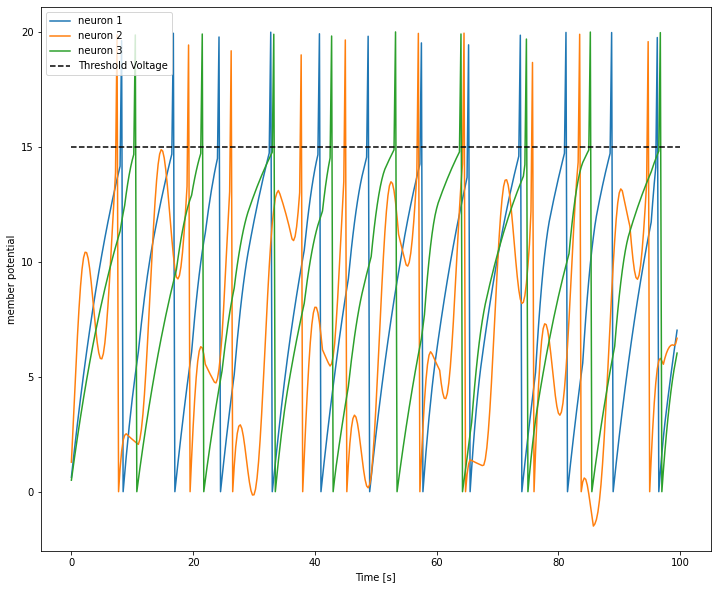

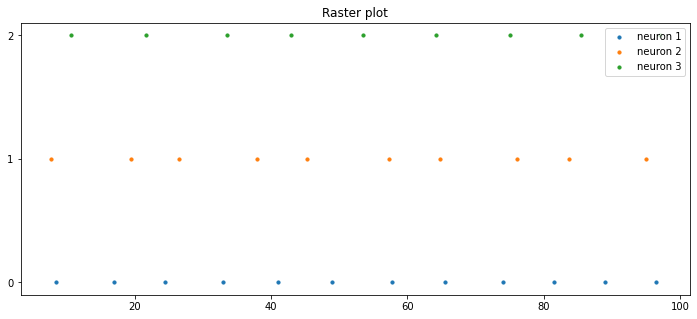

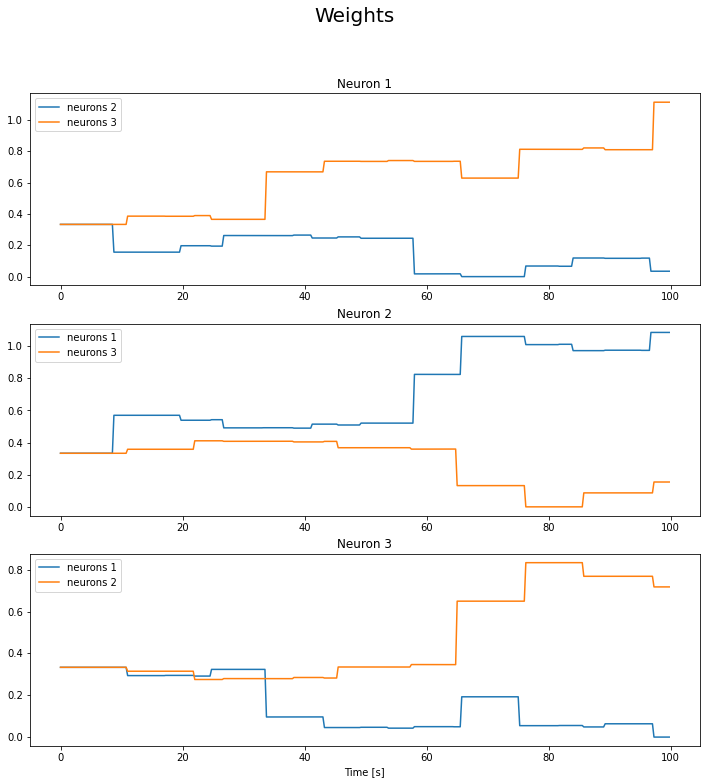

In [7]:
TIME_TOTAL = 100

n1 = Neuron(time_total=TIME_TOTAL, V_rest=0, V_reset=0, V_spike=5, V_threshold=15)
n2 = Neuron(time_total=TIME_TOTAL, V_rest=0, V_reset=0, V_spike=5, V_threshold=15)
n3 = Neuron(time_total=TIME_TOTAL, V_rest=0, V_reset=0, V_spike=5, V_threshold=15)

c1 = Current(lambda t : 2.5, TIME_TOTAL, 0.25)
c2 = Current(lambda t : 4 * math.sin(t + 0.9) + 2, TIME_TOTAL, 0.25)
c3 = Current(lambda t : 2, TIME_TOTAL, 0.25)

neurons = [n1, n2, n3]
delta_W, delta_T, w = simSTDP(neurons, [c1, c2, c3], time=TIME_TOTAL, A_neg=-1.5, A_plus=2)

print("weights:\n" , w[:,:,-1])

STDP_plots(neurons, delta_W, delta_T, w)

### sample 3
const, sin, step inputs

weights:
 [[0.33333333 0.1955022  0.        ]
 [0.96885135 0.33333333 0.33819377]
 [0.87247782 0.68558697 0.33333333]]


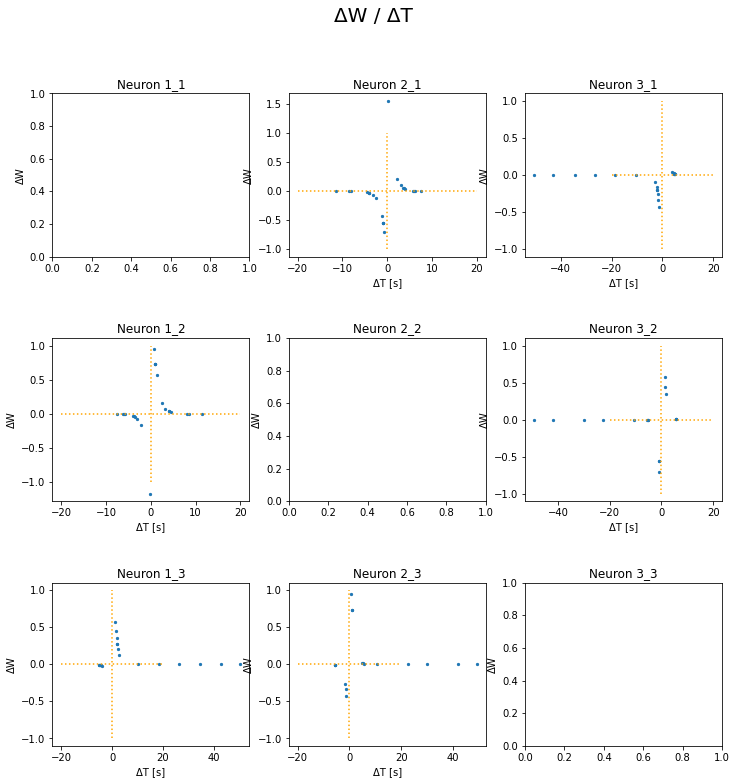

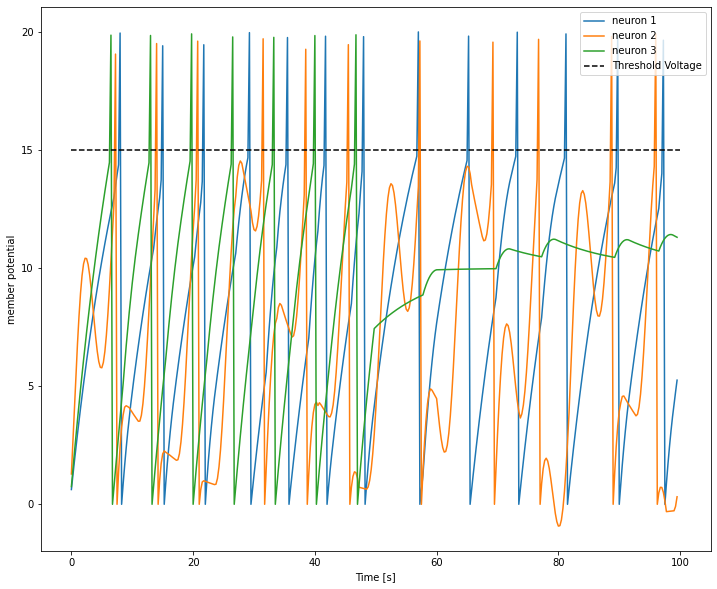

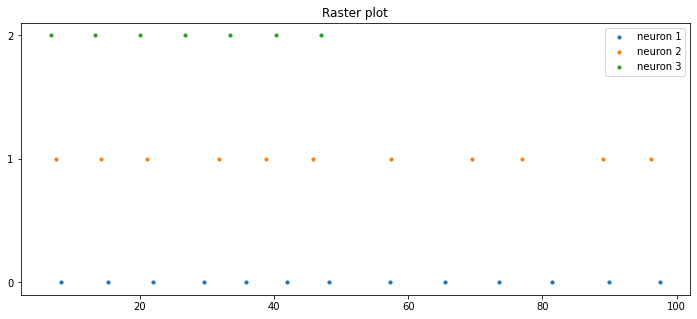

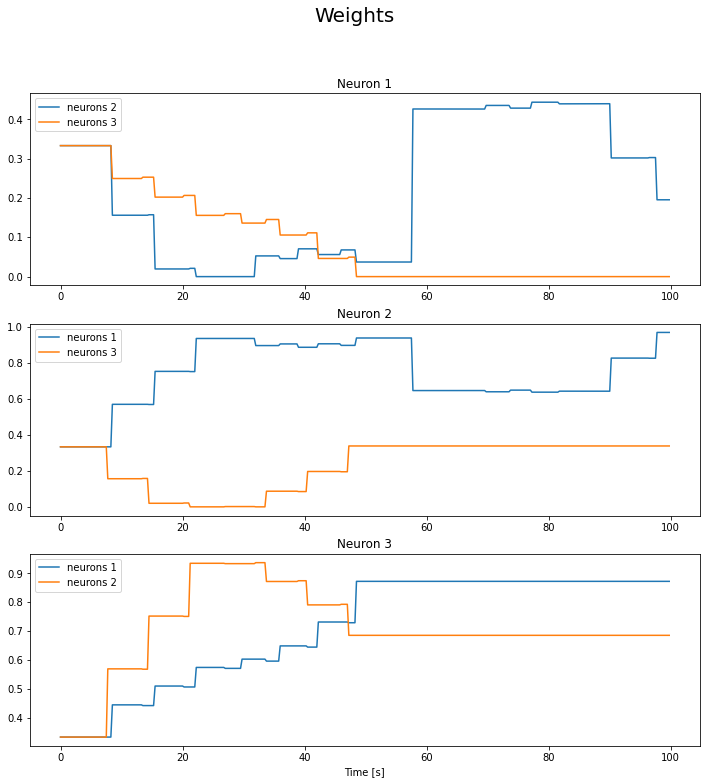

In [8]:
TIME_TOTAL = 100

n1 = Neuron(time_total=TIME_TOTAL, V_rest=0, V_reset=0, V_spike=5, V_threshold=15)
n2 = Neuron(time_total=TIME_TOTAL, V_rest=0, V_reset=0, V_spike=5, V_threshold=15)
n3 = Neuron(time_total=TIME_TOTAL, V_rest=0, V_reset=0, V_spike=5, V_threshold=15)

c1 = Current(lambda t : 2.5, TIME_TOTAL, 0.25)
c2 = Current(lambda t : 4 * math.sin(t + 0.9) + 2, TIME_TOTAL, 0.25)
c3 = Current(lambda t : 3 if t < 50 else 1, TIME_TOTAL, 0.25)

neurons = [n1, n2, n3]
delta_W, delta_T, w = simSTDP(neurons, [c1, c2, c3], time=TIME_TOTAL, A_neg=-1.5, A_plus=2)

print("weights:\n" , w[:,:,-1])

STDP_plots(neurons, delta_W, delta_T, w)

## Reward_Modulated STDP

In [9]:
class NeuralNetwork:
    def __init__(self, n_input, n_output, sample_neuron,
            A_plus = 2, A_neg = -1.5, tau_c = 5, tau_d = 5, tau_reward = 5):
        self.A_plus = A_plus
        self.A_neg = A_neg
        self.tau_c = tau_c
        self.tau_d = tau_d
        self.tau_reward = tau_reward
        self.sample_neuron = sample_neuron
        self.n_input = n_input
        self.n_output = n_output

    
    def _progress_bar(self, current, total, bar_length=20):
        fraction = current / total
        arrow = int(fraction * bar_length - 1) * '-' + '>'
        padding = int(bar_length - len(arrow)) * ' '
        ending = '\n' if current == total else '\r'
        print(f'Progress: [{arrow}{padding}] {int(fraction*100)}%', end=ending)
    
    def learn(self, I_in, actual_spikes, n_sample, time = 100, dt = 0.25):
        epochs = int(time / dt)

        # init measurements
        self.s = np.zeros((self.n_output, self.n_input, epochs))
        self.s.fill(1 / self.n_input)
        self.c = np.zeros((self.n_output, self.n_input, epochs))
        self.d = np.zeros((self.n_output, self.n_input, epochs))

        n = copy.deepcopy(self.sample_neuron)
        n.time_total = time
        input_neurons = []
        for j in range(n_sample):
            input_layer = []
            for _ in range(self.n_input):
                input_layer.append(copy.deepcopy(n))
            input_neurons.append(input_layer)
        output_neurons = []
        for j in range(n_sample):
            output_layer = []
            for _ in range(self.n_input):
                output_layer.append(copy.deepcopy(n))
            output_neurons.append(output_layer)

        I_out = []
        for _ in range(self.n_output):
            I_out.append(Current(lambda t : 0, time, 0.25))

        dop_effect = np.zeros((self.n_input, epochs)) # check when effect dopamine

        for t in range(1, epochs):
            for sample in range(n_sample):
                # first update neurons member potential
                for i in range(self.n_input):
                    fire = input_neurons[sample][i].update(I_in[sample][i].getCurrent(input_neurons[sample][i].pass_time))
                    if fire:
                        for j in range(self.n_output):
                            I_out[j].update_I(input_neurons[sample][i].pass_time, time, dt, self.s[j, i, t])
                for i in range(self.n_output):
                    output_neurons[sample][i].update(I_out[i].getCurrent(output_neurons[sample][i].pass_time))

                for i in range(self.n_input):
                    for j in range(self.n_output):
                        STDP = 0
                        DA = 0
                        # check spikes
                        # LTP
                        if (len(input_neurons[sample][i].spikes) != 0 and len(output_neurons[sample][j].spikes) != 0
                            and input_neurons[sample][i].spikes[-1] == input_neurons[sample][i].pass_time - dt
                        ):
                            if output_neurons[sample][j].pass_time > 0 and input_neurons[sample][i].pass_time > 0:
                                delta_t = output_neurons[sample][j].spikes[-1] - input_neurons[sample][i].spikes[-1]
                                if output_neurons[sample][j].spikes[-1] - input_neurons[sample][i].pass_time >= 0:
                                    STDP = self.A_plus * math.exp(-1 * abs(delta_t))
                                else:
                                    STDP = self.A_neg * math.exp(-1 * abs(delta_t))
                            dop_effect[i][t+5 if t+5 < epochs else epochs-1] = 1
                        #LTD
                        if (len(output_neurons[sample][j].spikes) != 0 and len(input_neurons[sample][i].spikes) != 0
                            and output_neurons[sample][j].spikes[-1] == output_neurons[sample][j].pass_time - dt
                        ):
                            delta_t = output_neurons[sample][j].spikes[-1] - input_neurons[sample][i].spikes[-1]
                            if delta_t >= 0:
                                STDP += self.A_plus * math.exp(-1 * abs(delta_t))
                            else:
                                STDP += self.A_neg * math.exp(-1 * abs(delta_t))
                        
                        # C
                        self.c[j, i, t] += (- self.c[j, i, t-1] / self.tau_c + STDP) * dt

                        # effect dopamine with reward
                        if dop_effect[i][t] == 1:
                            if (len(output_neurons[sample][j].spikes) != 0 and len(input_neurons[sample][i].spikes) != 0):
                                delta_t = output_neurons[sample][j].spikes[-1] - input_neurons[sample][i].spikes[-1]
                                if(actual_spikes[sample][j] == 1 and 0 <= delta_t):
                                    DA = self.A_plus * math.exp( -1 * abs(delta_t)) / self.tau_reward
                                else:
                                    DA = self.A_neg * math.exp( -1 * abs(delta_t)) / self.tau_reward
                        self.d[j, i, t] += (-self.d[j, i, t-1]/self.tau_d + DA) * dt
                        
                        # S
                        if 1 >= self.c[j, i, t] * self.d[j, i, t] * dt + self.s[j, i, t-1] >= 0:
                            add_S = self.c[j, i, t] * self.d[j, i, t] * dt
                        else:
                            add_S = 0
                        self.s[j, i, t] = add_S + self.s[j, i, t-1]
            self._progress_bar(t+1, epochs)
        return self.s, self.c, self.d

    def predict(self, I_in, time):
        n = Neuron(time_total=time, V_rest=0, V_reset=0, V_spike=1, V_threshold=2)
        input_neurons = []
        for _ in range(self.n_input):
            input_neurons.append(copy.deepcopy(n))
        output_neurons = []
        for _ in range(self.n_output):
            output_neurons.append(copy.deepcopy(n))

        C_i = Current(lambda t : 0, time, 0.25)
        I_out = [copy.deepcopy(C_i) for i in range(self.n_output)]
        count_fire = [0, 0]
        for t in range(1, len(input_neurons[0].times)):
            for i in range(self.n_input):
                fire = input_neurons[i].update(I_in[i].getCurrent(input_neurons[i].pass_time))

                if fire:
                    for j in range(self.n_output):
                        I_out[j].update_I(input_neurons[i].pass_time, time, input_neurons[i].dt, self.s[j, i, -1])
        
            for i in range(self.n_output):
                if output_neurons[i].update(I_out[i].getCurrent(input_neurons[i].pass_time)):
                    count_fire[i] += 1
        return count_fire

    def accuracy(self, spikes, I_test, time):
        correct = 0
        percent_accuracy = []

        for i in range(spikes.shape[0]):
            I_in = [
                Current(lambda t : I_test[i][0], time, 0.25),
                Current(lambda t : I_test[i][1], time, 0.25),
                Current(lambda t : I_test[i][2], time, 0.25),
                Current(lambda t : I_test[i][3], time, 0.25),
                Current(lambda t : I_test[i][4], time, 0.25),
            ]
            res = self.predict(I_in, time)
            actual = np.argmax(spikes[i])
            if(np.argmax(res) == actual): correct += 1
            percent_accuracy.append(res[actual] / np.sum(res) * 100)

        return correct / spikes.shape[0] * 100, np.mean(percent_accuracy)

In [10]:
TRAIN_DATASETS_FILENAME = "data/train_data.csv"
TEST_DATASETS_FILENAME = "data/test_data.csv"

train_data = pd.read_csv(TRAIN_DATASETS_FILENAME)
test_data = pd.read_csv(TEST_DATASETS_FILENAME)

In [11]:
train_data.tail(10)

,inpput_neuron_number,train_1,train_2,train_3,train_4,train_5,train_6,train_7,train_8,train_9,train_10
0,1,1,2,3,2,1,1,0,0,0,2
1,2,1,1,1,0,1,0,1,0,0,2
2,3,0,1,0,0,0,0,0,0,0,2
3,4,0,0,0,0,0,0,3,1,0,1
4,5,0,0,0,0,1,2,0,1,1,2
5,output_neuron_number,1,1,1,1,1,0,0,0,0,1


In [12]:
test_data.tail(10)

,inpput_neuron_number,test_1,test_2,test_3,test_4,test_5,test_6,test_7,test_8,test_9,test_10
0,1,1,0,0,2,1,1,3,0,1,2
1,2,0,1,2,2,2,0,1,0,2,2
2,3,0,0,0,1,0,0,0,2,0,2
3,4,0,0,0,0,0,0,2,2,1,3
4,5,0,0,0,0,0,3,3,2,1,3
5,output_neuron_number,1,1,1,1,1,0,0,0,1,0


In [13]:
# prepare train data
I_train = np.zeros((10, 5))
actual_spike = np.zeros((10, 2))

for i in range(10):
    data = train_data[f'train_{i+1}']
    I_train[i] = data[:-1]
    actual_spike[i,data[-1:]] = 1

# prepare test data
I_test = np.zeros((10, 5))
test_spike = np.zeros((10, 2))

for i in range(10):
    data = test_data[f'test_{i+1}']
    I_test[i] = data[:-1]
    test_spike[i,data[-1:]] = 1

In [14]:
TIME_TOTAL = 500
n = Neuron(time_total=TIME_TOTAL, V_rest=0, V_reset=0, V_spike=1, V_threshold=2)

I_in =[]
for I in I_train:
    temp = []
    for current in I:
        temp.append(Current(lambda t : current, TIME_TOTAL, 0.25))
    I_in.append(temp)
    
model = NeuralNetwork(5, 2, n)
s, c, d = model.learn(I_in, actual_spike, 10, TIME_TOTAL)
percent_correct, accuracy =  model.accuracy(test_spike, I_test, 100)
print(f"number of correct predict {int(percent_correct / 100 * 10)} / {10}")
print(f"with accuracy {accuracy}")


Progress: [------------------->] 100%
number of correct predict 10 / 10
with accuracy 78.22350452942003


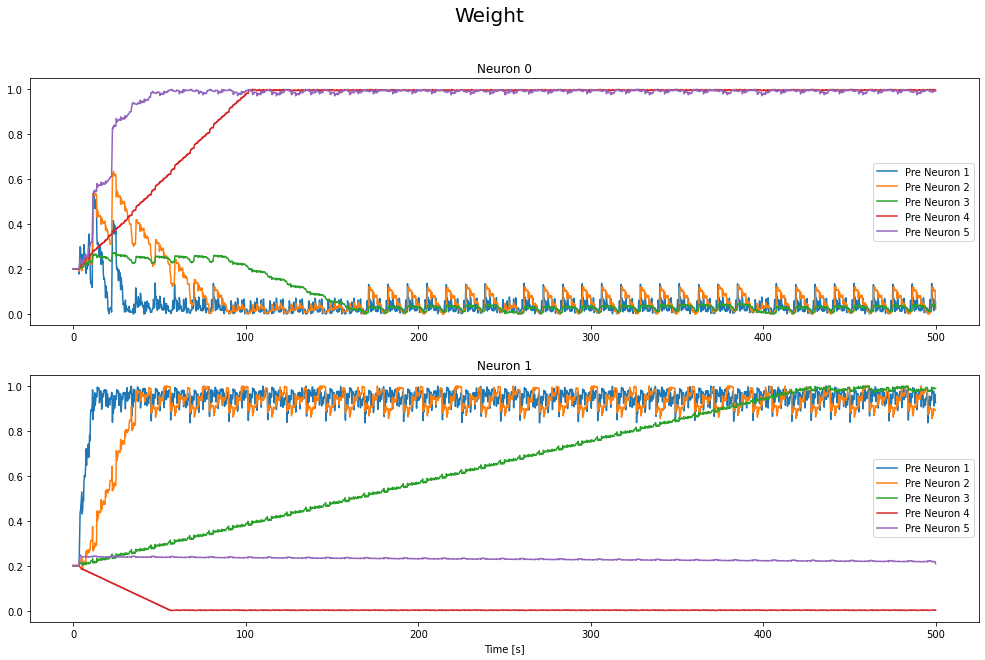

In [15]:
fig, axes = plt.subplots(2, figsize=(17,10))
for i in range(5):
    axes[0].plot(np.arange(0, 500, 0.25), s[0,i].T, label=f'Pre Neuron {i+1}')
axes[0].title.set_text(f'Neuron 0')
axes[0].legend()
for i in range(5):
    axes[1].plot(np.arange(0, 500, 0.25), s[1,i].T, label=f'Pre Neuron {i+1}')
axes[1].title.set_text(f'Neuron 1')
axes[1].legend()
plt.xlabel("Time [s]")
plt.suptitle('Weight',fontsize=20)
plt.show()

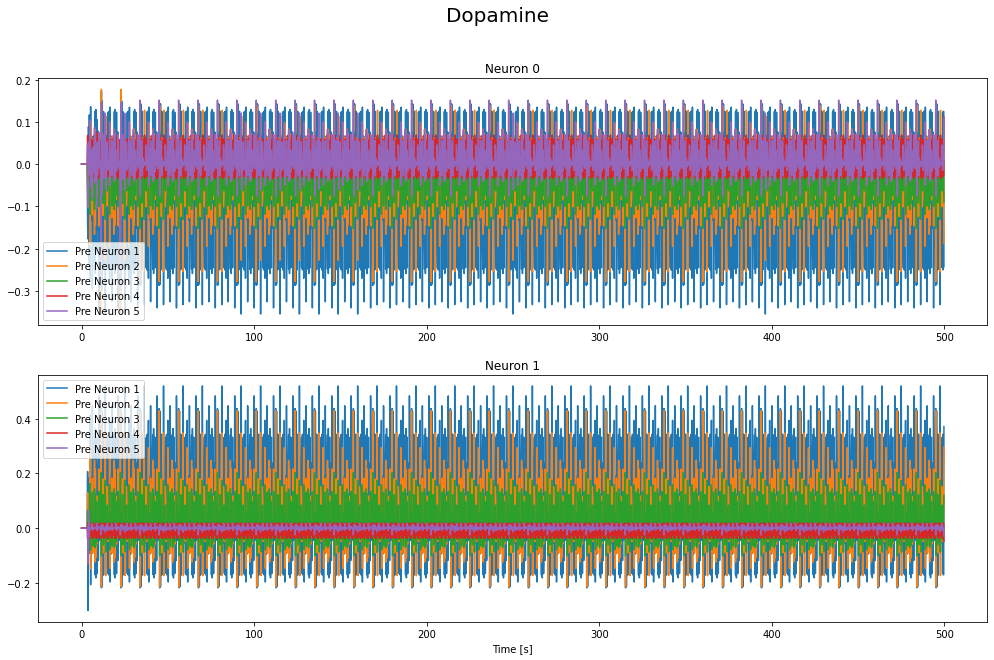

In [16]:
fig, axes = plt.subplots(2, figsize=(17,10))
for i in range(5):
    axes[0].plot(np.arange(0, 500, 0.25), d[0,i].T, label=f'Pre Neuron {i+1}')
axes[0].title.set_text(f'Neuron 0')
axes[0].legend()

for i in range(5):
    axes[1].plot(np.arange(0, 500, 0.25), d[1,i].T, label=f'Pre Neuron {i+1}')
axes[1].title.set_text(f'Neuron 1')
axes[1].legend()
plt.xlabel("Time [s]")
plt.suptitle('Dopamine',fontsize=20)
plt.show()

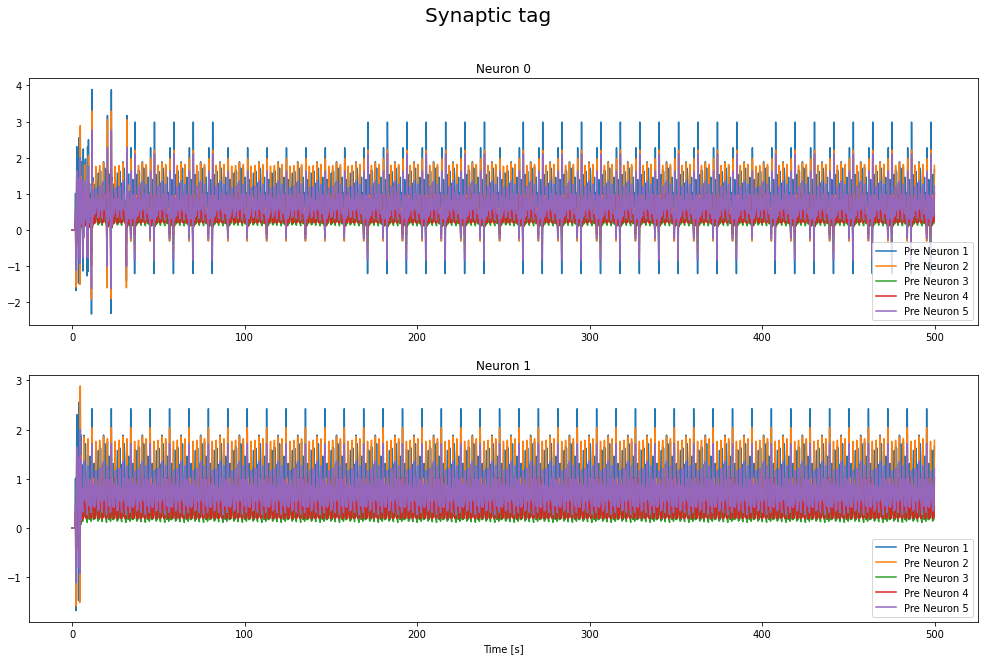

In [17]:
fig, axes = plt.subplots(2, figsize=(17,10))
for i in range(5):
    axes[0].plot(np.arange(0, 500, 0.25), c[0,i].T, label=f'Pre Neuron {i+1}')
axes[0].title.set_text(f'Neuron 0')
axes[0].legend()
for i in range(5):
    axes[1].plot(np.arange(0, 500, 0.25), c[1,i].T, label=f'Pre Neuron {i+1}')
axes[1].title.set_text(f'Neuron 1')
axes[1].legend()
plt.suptitle('Synaptic tag',fontsize=20)
plt.xlabel("Time [s]")
plt.show()